In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.core.pylabtools import figsize
from tqdm import tqdm

In [2]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# sns.set()

## Read Data

In [4]:
os.listdir('input')

['test.csv', 'train.csv', 'sample_submission.csv']

In [5]:
train_df = pd.read_csv('input/train.csv')
print(train_df.shape)
train_df.head(1)

(136950, 6)


,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63


In [6]:
test_df = pd.read_csv('input/test.csv')
test_df.shape

(27375, 5)

In [7]:
sample_sub = pd.read_csv('input/sample_submission.csv')
print(sample_sub.shape)
sample_sub.head(1)

(27375, 2)


,id,num_sold
0,136950,100


## Data Examination

### Column Check

#### No duplicate `id`

In [8]:
train_df.id.unique().shape, test_df.id.unique().shape

((136950,), (27375,))

#### No new `country` shows up in the test set

In [9]:
train_df.country.unique(), test_df.country.unique()

(array(['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain'], dtype=object),
 array(['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain'], dtype=object))

#### No new `store` shows up in the test set

In [10]:
train_df.store.unique(), test_df.store.unique()

(array(['Kaggle Learn', 'Kaggle Store', 'Kagglazon'], dtype=object),
 array(['Kaggle Learn', 'Kaggle Store', 'Kagglazon'], dtype=object))

#### No new `product` shows up in the test set

In [11]:
train_df['product'].unique(), test_df['product'].unique()

(array(['Using LLMs to Improve Your Coding',
        'Using LLMs to Train More LLMs',
        'Using LLMs to Win Friends and Influence People',
        'Using LLMs to Win More Kaggle Competitions',
        'Using LLMs to Write Better'], dtype=object),
 array(['Using LLMs to Improve Your Coding',
        'Using LLMs to Train More LLMs',
        'Using LLMs to Win Friends and Influence People',
        'Using LLMs to Win More Kaggle Competitions',
        'Using LLMs to Write Better'], dtype=object))

## EDA

In [12]:
cats = ['country', 'store', 'product']
temp = train_df.copy()
temp['comb'] = temp[cats].apply(lambda x: '|'.join(list(x)), 
                                axis=1)
temp = temp.pivot(index='date', 
                  columns='comb',
                  values='num_sold')
temp.head()

comb,Argentina|Kagglazon|Using LLMs to Improve Your Coding,Argentina|Kagglazon|Using LLMs to Train More LLMs,Argentina|Kagglazon|Using LLMs to Win Friends and Influence People,Argentina|Kagglazon|Using LLMs to Win More Kaggle Competitions,Argentina|Kagglazon|Using LLMs to Write Better,Argentina|Kaggle Learn|Using LLMs to Improve Your Coding,Argentina|Kaggle Learn|Using LLMs to Train More LLMs,Argentina|Kaggle Learn|Using LLMs to Win Friends and Influence People,Argentina|Kaggle Learn|Using LLMs to Win More Kaggle Competitions,Argentina|Kaggle Learn|Using LLMs to Write Better,...,Spain|Kaggle Learn|Using LLMs to Improve Your Coding,Spain|Kaggle Learn|Using LLMs to Train More LLMs,Spain|Kaggle Learn|Using LLMs to Win Friends and Influence People,Spain|Kaggle Learn|Using LLMs to Win More Kaggle Competitions,Spain|Kaggle Learn|Using LLMs to Write Better,Spain|Kaggle Store|Using LLMs to Improve Your Coding,Spain|Kaggle Store|Using LLMs to Train More LLMs,Spain|Kaggle Store|Using LLMs to Win Friends and Influence People,Spain|Kaggle Store|Using LLMs to Win More Kaggle Competitions,Spain|Kaggle Store|Using LLMs to Write Better
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,340,371,53,364,285,63,66,9,59,49,...,122,125,20,106,90,177,198,29,184,139
2017-01-02,250,273,52,236,206,51,47,7,43,35,...,106,100,13,94,68,145,140,22,125,110
2017-01-03,267,253,35,252,201,44,45,7,41,37,...,85,90,14,80,60,161,133,20,118,106
2017-01-04,236,243,34,224,194,44,42,7,40,32,...,79,76,13,69,69,128,121,19,126,99
2017-01-05,247,231,38,207,179,40,46,6,39,32,...,80,83,12,77,60,122,129,20,118,104


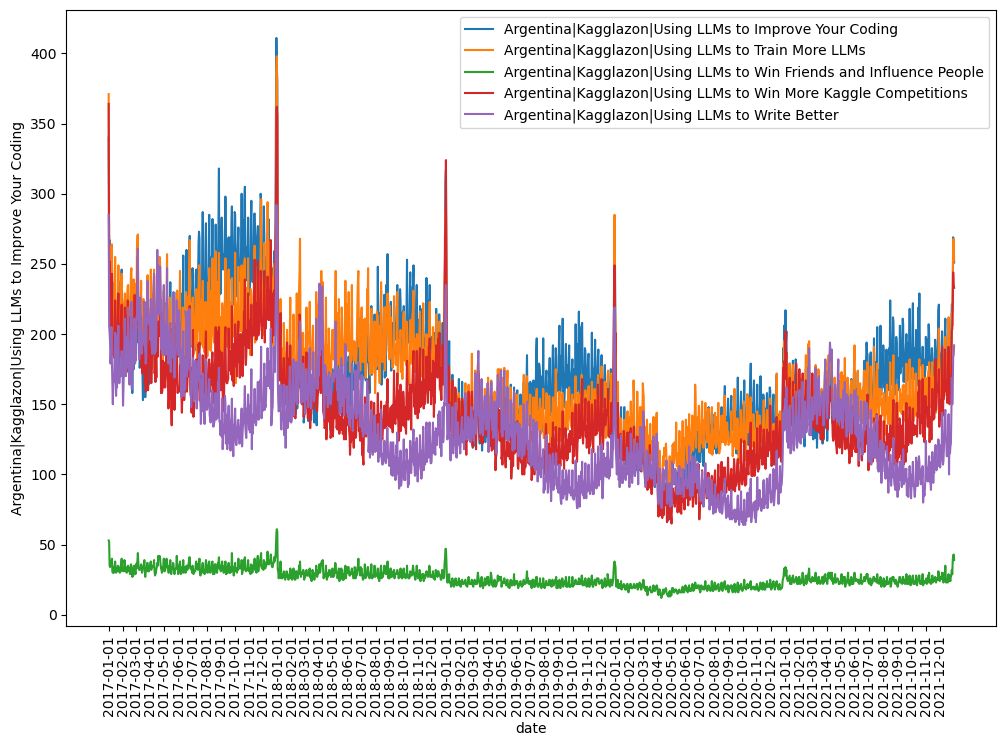

In [13]:
figsize(12, 8)

fig, ax = plt.subplots(1, 1)

for col in temp.columns:
    if col.startswith('Argentina|Kagglazon'):
        sns.lineplot(temp.index,
                     temp[col],
                     label=col)
plt.legend()

xticklabels = [x.get_text() for x in ax.get_xticklabels()]
xticks = []
xlabels = []
for i, label in enumerate(xticklabels, 0):
    if label.endswith('-01'):
        xlabels.append(label)
        xticks.append(i)
        
_ = ax.set_xticks(xticks, xlabels, rotation=90)

## Modeling

In [14]:
train_df['comb'] = train_df[cats].apply(lambda x: '|'.join(list(x)), 
                                        axis=1)

In [15]:
train_df['y'] = train_df['num_sold']
train_df['ds'] = train_df['date']

In [16]:
groups_by_comb = train_df.groupby('comb')
len(groups_by_comb.groups.keys())

75

### Define Function

In [17]:
def train_and_forecast(group):
    # Train
    m = Prophet()
    m.fit(group)
    
    # Predict
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast['comb'] = group['comb'].iloc[0]
    
    # Return 
    return m, forecast[['ds', 'comb', 'yhat', 'yhat_upper', 'yhat_lower']]

In [18]:
preds = pd.DataFrame()
models = []

for comb in train_df.comb.unique():
    group = groups_by_comb.get_group(comb)
    m, forecast = train_and_forecast(group)
    preds = pd.concat((preds, forecast))
    models.append(m)
    
preds.head()

14:50:21 - cmdstanpy - INFO - Chain [1] start processing
14:50:21 - cmdstanpy - INFO - Chain [1] done processing
14:50:22 - cmdstanpy - INFO - Chain [1] start processing
14:50:22 - cmdstanpy - INFO - Chain [1] done processing
14:50:23 - cmdstanpy - INFO - Chain [1] start processing
14:50:23 - cmdstanpy - INFO - Chain [1] done processing
14:50:24 - cmdstanpy - INFO - Chain [1] start processing
14:50:24 - cmdstanpy - INFO - Chain [1] done processing
14:50:25 - cmdstanpy - INFO - Chain [1] start processing
14:50:25 - cmdstanpy - INFO - Chain [1] done processing
14:50:26 - cmdstanpy - INFO - Chain [1] start processing
14:50:26 - cmdstanpy - INFO - Chain [1] done processing
14:50:27 - cmdstanpy - INFO - Chain [1] start processing
14:50:27 - cmdstanpy - INFO - Chain [1] done processing
14:50:28 - cmdstanpy - INFO - Chain [1] start processing
14:50:28 - cmdstanpy - INFO - Chain [1] done processing
14:50:28 - cmdstanpy - INFO - Chain [1] start processing
14:50:29 - cmdstanpy - INFO - Chain [1]

14:51:33 - cmdstanpy - INFO - Chain [1] done processing
14:51:34 - cmdstanpy - INFO - Chain [1] start processing
14:51:34 - cmdstanpy - INFO - Chain [1] done processing
14:51:35 - cmdstanpy - INFO - Chain [1] start processing
14:51:35 - cmdstanpy - INFO - Chain [1] done processing


,ds,comb,yhat,yhat_upper,yhat_lower
0,2017-01-01,Argentina|Kaggle Learn|Using LLMs to Improve Y...,47.382357,50.954983,43.682469
1,2017-01-02,Argentina|Kaggle Learn|Using LLMs to Improve Y...,41.278726,45.091134,38.112695
2,2017-01-03,Argentina|Kaggle Learn|Using LLMs to Improve Y...,40.747431,44.335999,36.924841
3,2017-01-04,Argentina|Kaggle Learn|Using LLMs to Improve Y...,40.520659,44.244781,36.946607
4,2017-01-05,Argentina|Kaggle Learn|Using LLMs to Improve Y...,40.254745,43.771878,36.718684


## Evaluation

In [48]:
def get_smape(m):
    m_cv = cross_validation(model=m, 
                            initial='1000 days',
                            period='30 days',
                            horizon='365 days')
    pm = performance_metrics(m_cv)
    return pm[pm['horizon'] == '365 days']['smape'].values[0]

In [50]:
smapes = [get_smape(m) for m in tqdm(models)]

  0%|                                                    | 0/75 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

15:10:46 - cmdstanpy - INFO - Chain [1] start processing
15:10:46 - cmdstanpy - INFO - Chain [1] done processing
15:10:46 - cmdstanpy - INFO - Chain [1] start processing
15:10:46 - cmdstanpy - INFO - Chain [1] done processing
15:10:46 - cmdstanpy - INFO - Chain [1] start processing
15:10:47 - cmdstanpy - INFO - Chain [1] done processing
15:10:47 - cmdstanpy - INFO - Chain [1] start processing
15:10:47 - cmdstanpy - INFO - Chain [1] done processing
15:10:47 - cmdstanpy - INFO - Chain [1] start processing
15:10:47 - cmdstanpy - INFO - Chain [1] done processing
15:10:48 - cmdstanpy - INFO - Chain [1] start processing
15:10:48 - cmdstanpy - INFO - Chain [1] done processing
15:10:48 - cmdstanpy - INFO - Chain [1] start processing
15:10:48 - cmdstanpy - INFO - Chain [1] done processing
15:10:48 - cmdstanpy - INFO - Chain [1] start processing
15:10:49 - cmdstanpy - INFO - Chain [1] done processing
15:10:49 - cmdstanpy - INFO - Chain [1] start processing
15:10:49 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:10:53 - cmdstanpy - INFO - Chain [1] start processing
15:10:53 - cmdstanpy - INFO - Chain [1] done processing
15:10:54 - cmdstanpy - INFO - Chain [1] start processing
15:10:54 - cmdstanpy - INFO - Chain [1] done processing
15:10:54 - cmdstanpy - INFO - Chain [1] start processing
15:10:54 - cmdstanpy - INFO - Chain [1] done processing
15:10:55 - cmdstanpy - INFO - Chain [1] start processing
15:10:55 - cmdstanpy - INFO - Chain [1] done processing
15:10:55 - cmdstanpy - INFO - Chain [1] start processing
15:10:55 - cmdstanpy - INFO - Chain [1] done processing
15:10:55 - cmdstanpy - INFO - Chain [1] start processing
15:10:55 - cmdstanpy - INFO - Chain [1] done processing
15:10:56 - cmdstanpy - INFO - Chain [1] start processing
15:10:56 - cmdstanpy - INFO - Chain [1] done processing
15:10:56 - cmdstanpy - INFO - Chain [1] start processing
15:10:56 - cmdstanpy - INFO - Chain [1] done processing
15:10:56 - cmdstanpy - INFO - Chain [1] start processing
15:10:57 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:11:01 - cmdstanpy - INFO - Chain [1] start processing
15:11:01 - cmdstanpy - INFO - Chain [1] done processing
15:11:01 - cmdstanpy - INFO - Chain [1] start processing
15:11:01 - cmdstanpy - INFO - Chain [1] done processing
15:11:01 - cmdstanpy - INFO - Chain [1] start processing
15:11:02 - cmdstanpy - INFO - Chain [1] done processing
15:11:02 - cmdstanpy - INFO - Chain [1] start processing
15:11:02 - cmdstanpy - INFO - Chain [1] done processing
15:11:02 - cmdstanpy - INFO - Chain [1] start processing
15:11:02 - cmdstanpy - INFO - Chain [1] done processing
15:11:03 - cmdstanpy - INFO - Chain [1] start processing
15:11:03 - cmdstanpy - INFO - Chain [1] done processing
15:11:03 - cmdstanpy - INFO - Chain [1] start processing
15:11:03 - cmdstanpy - INFO - Chain [1] done processing
15:11:03 - cmdstanpy - INFO - Chain [1] start processing
15:11:03 - cmdstanpy - INFO - Chain [1] done processing
15:11:04 - cmdstanpy - INFO - Chain [1] start processing
15:11:04 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:11:08 - cmdstanpy - INFO - Chain [1] start processing
15:11:08 - cmdstanpy - INFO - Chain [1] done processing
15:11:08 - cmdstanpy - INFO - Chain [1] start processing
15:11:08 - cmdstanpy - INFO - Chain [1] done processing
15:11:09 - cmdstanpy - INFO - Chain [1] start processing
15:11:09 - cmdstanpy - INFO - Chain [1] done processing
15:11:09 - cmdstanpy - INFO - Chain [1] start processing
15:11:09 - cmdstanpy - INFO - Chain [1] done processing
15:11:10 - cmdstanpy - INFO - Chain [1] start processing
15:11:10 - cmdstanpy - INFO - Chain [1] done processing
15:11:10 - cmdstanpy - INFO - Chain [1] start processing
15:11:10 - cmdstanpy - INFO - Chain [1] done processing
15:11:10 - cmdstanpy - INFO - Chain [1] start processing
15:11:10 - cmdstanpy - INFO - Chain [1] done processing
15:11:11 - cmdstanpy - INFO - Chain [1] start processing
15:11:11 - cmdstanpy - INFO - Chain [1] done processing
15:11:11 - cmdstanpy - INFO - Chain [1] start processing
15:11:11 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:11:15 - cmdstanpy - INFO - Chain [1] start processing
15:11:15 - cmdstanpy - INFO - Chain [1] done processing
15:11:16 - cmdstanpy - INFO - Chain [1] start processing
15:11:16 - cmdstanpy - INFO - Chain [1] done processing
15:11:16 - cmdstanpy - INFO - Chain [1] start processing
15:11:16 - cmdstanpy - INFO - Chain [1] done processing
15:11:16 - cmdstanpy - INFO - Chain [1] start processing
15:11:16 - cmdstanpy - INFO - Chain [1] done processing
15:11:17 - cmdstanpy - INFO - Chain [1] start processing
15:11:17 - cmdstanpy - INFO - Chain [1] done processing
15:11:17 - cmdstanpy - INFO - Chain [1] start processing
15:11:17 - cmdstanpy - INFO - Chain [1] done processing
15:11:17 - cmdstanpy - INFO - Chain [1] start processing
15:11:17 - cmdstanpy - INFO - Chain [1] done processing
15:11:18 - cmdstanpy - INFO - Chain [1] start processing
15:11:18 - cmdstanpy - INFO - Chain [1] done processing
15:11:18 - cmdstanpy - INFO - Chain [1] start processing
15:11:18 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:11:22 - cmdstanpy - INFO - Chain [1] start processing
15:11:22 - cmdstanpy - INFO - Chain [1] done processing
15:11:22 - cmdstanpy - INFO - Chain [1] start processing
15:11:23 - cmdstanpy - INFO - Chain [1] done processing
15:11:23 - cmdstanpy - INFO - Chain [1] start processing
15:11:23 - cmdstanpy - INFO - Chain [1] done processing
15:11:23 - cmdstanpy - INFO - Chain [1] start processing
15:11:23 - cmdstanpy - INFO - Chain [1] done processing
15:11:24 - cmdstanpy - INFO - Chain [1] start processing
15:11:24 - cmdstanpy - INFO - Chain [1] done processing
15:11:24 - cmdstanpy - INFO - Chain [1] start processing
15:11:24 - cmdstanpy - INFO - Chain [1] done processing
15:11:24 - cmdstanpy - INFO - Chain [1] start processing
15:11:25 - cmdstanpy - INFO - Chain [1] done processing
15:11:25 - cmdstanpy - INFO - Chain [1] start processing
15:11:25 - cmdstanpy - INFO - Chain [1] done processing
15:11:25 - cmdstanpy - INFO - Chain [1] start processing
15:11:25 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:11:29 - cmdstanpy - INFO - Chain [1] start processing
15:11:29 - cmdstanpy - INFO - Chain [1] done processing
15:11:30 - cmdstanpy - INFO - Chain [1] start processing
15:11:30 - cmdstanpy - INFO - Chain [1] done processing
15:11:30 - cmdstanpy - INFO - Chain [1] start processing
15:11:30 - cmdstanpy - INFO - Chain [1] done processing
15:11:30 - cmdstanpy - INFO - Chain [1] start processing
15:11:30 - cmdstanpy - INFO - Chain [1] done processing
15:11:31 - cmdstanpy - INFO - Chain [1] start processing
15:11:31 - cmdstanpy - INFO - Chain [1] done processing
15:11:31 - cmdstanpy - INFO - Chain [1] start processing
15:11:31 - cmdstanpy - INFO - Chain [1] done processing
15:11:32 - cmdstanpy - INFO - Chain [1] start processing
15:11:32 - cmdstanpy - INFO - Chain [1] done processing
15:11:32 - cmdstanpy - INFO - Chain [1] start processing
15:11:32 - cmdstanpy - INFO - Chain [1] done processing
15:11:32 - cmdstanpy - INFO - Chain [1] start processing
15:11:32 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:11:36 - cmdstanpy - INFO - Chain [1] start processing
15:11:37 - cmdstanpy - INFO - Chain [1] done processing
15:11:37 - cmdstanpy - INFO - Chain [1] start processing
15:11:37 - cmdstanpy - INFO - Chain [1] done processing
15:11:37 - cmdstanpy - INFO - Chain [1] start processing
15:11:37 - cmdstanpy - INFO - Chain [1] done processing
15:11:38 - cmdstanpy - INFO - Chain [1] start processing
15:11:38 - cmdstanpy - INFO - Chain [1] done processing
15:11:38 - cmdstanpy - INFO - Chain [1] start processing
15:11:38 - cmdstanpy - INFO - Chain [1] done processing
15:11:38 - cmdstanpy - INFO - Chain [1] start processing
15:11:38 - cmdstanpy - INFO - Chain [1] done processing
15:11:39 - cmdstanpy - INFO - Chain [1] start processing
15:11:39 - cmdstanpy - INFO - Chain [1] done processing
15:11:39 - cmdstanpy - INFO - Chain [1] start processing
15:11:39 - cmdstanpy - INFO - Chain [1] done processing
15:11:39 - cmdstanpy - INFO - Chain [1] start processing
15:11:39 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:11:43 - cmdstanpy - INFO - Chain [1] start processing
15:11:43 - cmdstanpy - INFO - Chain [1] done processing
15:11:44 - cmdstanpy - INFO - Chain [1] start processing
15:11:44 - cmdstanpy - INFO - Chain [1] done processing
15:11:44 - cmdstanpy - INFO - Chain [1] start processing
15:11:44 - cmdstanpy - INFO - Chain [1] done processing
15:11:44 - cmdstanpy - INFO - Chain [1] start processing
15:11:44 - cmdstanpy - INFO - Chain [1] done processing
15:11:45 - cmdstanpy - INFO - Chain [1] start processing
15:11:45 - cmdstanpy - INFO - Chain [1] done processing
15:11:45 - cmdstanpy - INFO - Chain [1] start processing
15:11:45 - cmdstanpy - INFO - Chain [1] done processing
15:11:45 - cmdstanpy - INFO - Chain [1] start processing
15:11:45 - cmdstanpy - INFO - Chain [1] done processing
15:11:46 - cmdstanpy - INFO - Chain [1] start processing
15:11:46 - cmdstanpy - INFO - Chain [1] done processing
15:11:46 - cmdstanpy - INFO - Chain [1] start processing
15:11:46 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:11:50 - cmdstanpy - INFO - Chain [1] start processing
15:11:50 - cmdstanpy - INFO - Chain [1] done processing
15:11:50 - cmdstanpy - INFO - Chain [1] start processing
15:11:50 - cmdstanpy - INFO - Chain [1] done processing
15:11:51 - cmdstanpy - INFO - Chain [1] start processing
15:11:51 - cmdstanpy - INFO - Chain [1] done processing
15:11:51 - cmdstanpy - INFO - Chain [1] start processing
15:11:51 - cmdstanpy - INFO - Chain [1] done processing
15:11:51 - cmdstanpy - INFO - Chain [1] start processing
15:11:51 - cmdstanpy - INFO - Chain [1] done processing
15:11:52 - cmdstanpy - INFO - Chain [1] start processing
15:11:52 - cmdstanpy - INFO - Chain [1] done processing
15:11:52 - cmdstanpy - INFO - Chain [1] start processing
15:11:52 - cmdstanpy - INFO - Chain [1] done processing
15:11:52 - cmdstanpy - INFO - Chain [1] start processing
15:11:52 - cmdstanpy - INFO - Chain [1] done processing
15:11:53 - cmdstanpy - INFO - Chain [1] start processing
15:11:53 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:11:57 - cmdstanpy - INFO - Chain [1] start processing
15:11:57 - cmdstanpy - INFO - Chain [1] done processing
15:11:57 - cmdstanpy - INFO - Chain [1] start processing
15:11:57 - cmdstanpy - INFO - Chain [1] done processing
15:11:58 - cmdstanpy - INFO - Chain [1] start processing
15:11:58 - cmdstanpy - INFO - Chain [1] done processing
15:11:58 - cmdstanpy - INFO - Chain [1] start processing
15:11:58 - cmdstanpy - INFO - Chain [1] done processing
15:11:58 - cmdstanpy - INFO - Chain [1] start processing
15:11:58 - cmdstanpy - INFO - Chain [1] done processing
15:11:59 - cmdstanpy - INFO - Chain [1] start processing
15:11:59 - cmdstanpy - INFO - Chain [1] done processing
15:11:59 - cmdstanpy - INFO - Chain [1] start processing
15:11:59 - cmdstanpy - INFO - Chain [1] done processing
15:11:59 - cmdstanpy - INFO - Chain [1] start processing
15:11:59 - cmdstanpy - INFO - Chain [1] done processing
15:12:00 - cmdstanpy - INFO - Chain [1] start processing
15:12:00 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:12:04 - cmdstanpy - INFO - Chain [1] start processing
15:12:04 - cmdstanpy - INFO - Chain [1] done processing
15:12:04 - cmdstanpy - INFO - Chain [1] start processing
15:12:04 - cmdstanpy - INFO - Chain [1] done processing
15:12:04 - cmdstanpy - INFO - Chain [1] start processing
15:12:05 - cmdstanpy - INFO - Chain [1] done processing
15:12:05 - cmdstanpy - INFO - Chain [1] start processing
15:12:05 - cmdstanpy - INFO - Chain [1] done processing
15:12:05 - cmdstanpy - INFO - Chain [1] start processing
15:12:05 - cmdstanpy - INFO - Chain [1] done processing
15:12:06 - cmdstanpy - INFO - Chain [1] start processing
15:12:06 - cmdstanpy - INFO - Chain [1] done processing
15:12:06 - cmdstanpy - INFO - Chain [1] start processing
15:12:06 - cmdstanpy - INFO - Chain [1] done processing
15:12:07 - cmdstanpy - INFO - Chain [1] start processing
15:12:07 - cmdstanpy - INFO - Chain [1] done processing
15:12:07 - cmdstanpy - INFO - Chain [1] start processing
15:12:07 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:12:11 - cmdstanpy - INFO - Chain [1] start processing
15:12:11 - cmdstanpy - INFO - Chain [1] done processing
15:12:12 - cmdstanpy - INFO - Chain [1] start processing
15:12:12 - cmdstanpy - INFO - Chain [1] done processing
15:12:12 - cmdstanpy - INFO - Chain [1] start processing
15:12:12 - cmdstanpy - INFO - Chain [1] done processing
15:12:12 - cmdstanpy - INFO - Chain [1] start processing
15:12:13 - cmdstanpy - INFO - Chain [1] done processing
15:12:13 - cmdstanpy - INFO - Chain [1] start processing
15:12:13 - cmdstanpy - INFO - Chain [1] done processing
15:12:13 - cmdstanpy - INFO - Chain [1] start processing
15:12:13 - cmdstanpy - INFO - Chain [1] done processing
15:12:14 - cmdstanpy - INFO - Chain [1] start processing
15:12:14 - cmdstanpy - INFO - Chain [1] done processing
15:12:14 - cmdstanpy - INFO - Chain [1] start processing
15:12:14 - cmdstanpy - INFO - Chain [1] done processing
15:12:14 - cmdstanpy - INFO - Chain [1] start processing
15:12:14 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:12:18 - cmdstanpy - INFO - Chain [1] start processing
15:12:18 - cmdstanpy - INFO - Chain [1] done processing
15:12:19 - cmdstanpy - INFO - Chain [1] start processing
15:12:19 - cmdstanpy - INFO - Chain [1] done processing
15:12:19 - cmdstanpy - INFO - Chain [1] start processing
15:12:19 - cmdstanpy - INFO - Chain [1] done processing
15:12:19 - cmdstanpy - INFO - Chain [1] start processing
15:12:19 - cmdstanpy - INFO - Chain [1] done processing
15:12:20 - cmdstanpy - INFO - Chain [1] start processing
15:12:20 - cmdstanpy - INFO - Chain [1] done processing
15:12:20 - cmdstanpy - INFO - Chain [1] start processing
15:12:20 - cmdstanpy - INFO - Chain [1] done processing
15:12:20 - cmdstanpy - INFO - Chain [1] start processing
15:12:20 - cmdstanpy - INFO - Chain [1] done processing
15:12:21 - cmdstanpy - INFO - Chain [1] start processing
15:12:21 - cmdstanpy - INFO - Chain [1] done processing
15:12:21 - cmdstanpy - INFO - Chain [1] start processing
15:12:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:12:25 - cmdstanpy - INFO - Chain [1] start processing
15:12:25 - cmdstanpy - INFO - Chain [1] done processing
15:12:25 - cmdstanpy - INFO - Chain [1] start processing
15:12:25 - cmdstanpy - INFO - Chain [1] done processing
15:12:26 - cmdstanpy - INFO - Chain [1] start processing
15:12:26 - cmdstanpy - INFO - Chain [1] done processing
15:12:26 - cmdstanpy - INFO - Chain [1] start processing
15:12:26 - cmdstanpy - INFO - Chain [1] done processing
15:12:26 - cmdstanpy - INFO - Chain [1] start processing
15:12:26 - cmdstanpy - INFO - Chain [1] done processing
15:12:27 - cmdstanpy - INFO - Chain [1] start processing
15:12:27 - cmdstanpy - INFO - Chain [1] done processing
15:12:27 - cmdstanpy - INFO - Chain [1] start processing
15:12:27 - cmdstanpy - INFO - Chain [1] done processing
15:12:27 - cmdstanpy - INFO - Chain [1] start processing
15:12:27 - cmdstanpy - INFO - Chain [1] done processing
15:12:28 - cmdstanpy - INFO - Chain [1] start processing
15:12:28 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:12:32 - cmdstanpy - INFO - Chain [1] start processing
15:12:32 - cmdstanpy - INFO - Chain [1] done processing
15:12:32 - cmdstanpy - INFO - Chain [1] start processing
15:12:32 - cmdstanpy - INFO - Chain [1] done processing
15:12:32 - cmdstanpy - INFO - Chain [1] start processing
15:12:33 - cmdstanpy - INFO - Chain [1] done processing
15:12:33 - cmdstanpy - INFO - Chain [1] start processing
15:12:33 - cmdstanpy - INFO - Chain [1] done processing
15:12:33 - cmdstanpy - INFO - Chain [1] start processing
15:12:33 - cmdstanpy - INFO - Chain [1] done processing
15:12:34 - cmdstanpy - INFO - Chain [1] start processing
15:12:34 - cmdstanpy - INFO - Chain [1] done processing
15:12:34 - cmdstanpy - INFO - Chain [1] start processing
15:12:34 - cmdstanpy - INFO - Chain [1] done processing
15:12:34 - cmdstanpy - INFO - Chain [1] start processing
15:12:35 - cmdstanpy - INFO - Chain [1] done processing
15:12:35 - cmdstanpy - INFO - Chain [1] start processing
15:12:35 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:12:39 - cmdstanpy - INFO - Chain [1] start processing
15:12:39 - cmdstanpy - INFO - Chain [1] done processing
15:12:40 - cmdstanpy - INFO - Chain [1] start processing
15:12:40 - cmdstanpy - INFO - Chain [1] done processing
15:12:40 - cmdstanpy - INFO - Chain [1] start processing
15:12:40 - cmdstanpy - INFO - Chain [1] done processing
15:12:40 - cmdstanpy - INFO - Chain [1] start processing
15:12:40 - cmdstanpy - INFO - Chain [1] done processing
15:12:41 - cmdstanpy - INFO - Chain [1] start processing
15:12:41 - cmdstanpy - INFO - Chain [1] done processing
15:12:41 - cmdstanpy - INFO - Chain [1] start processing
15:12:41 - cmdstanpy - INFO - Chain [1] done processing
15:12:41 - cmdstanpy - INFO - Chain [1] start processing
15:12:42 - cmdstanpy - INFO - Chain [1] done processing
15:12:42 - cmdstanpy - INFO - Chain [1] start processing
15:12:42 - cmdstanpy - INFO - Chain [1] done processing
15:12:42 - cmdstanpy - INFO - Chain [1] start processing
15:12:42 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:12:47 - cmdstanpy - INFO - Chain [1] start processing
15:12:47 - cmdstanpy - INFO - Chain [1] done processing
15:12:47 - cmdstanpy - INFO - Chain [1] start processing
15:12:47 - cmdstanpy - INFO - Chain [1] done processing
15:12:48 - cmdstanpy - INFO - Chain [1] start processing
15:12:48 - cmdstanpy - INFO - Chain [1] done processing
15:12:48 - cmdstanpy - INFO - Chain [1] start processing
15:12:48 - cmdstanpy - INFO - Chain [1] done processing
15:12:48 - cmdstanpy - INFO - Chain [1] start processing
15:12:48 - cmdstanpy - INFO - Chain [1] done processing
15:12:49 - cmdstanpy - INFO - Chain [1] start processing
15:12:49 - cmdstanpy - INFO - Chain [1] done processing
15:12:49 - cmdstanpy - INFO - Chain [1] start processing
15:12:49 - cmdstanpy - INFO - Chain [1] done processing
15:12:50 - cmdstanpy - INFO - Chain [1] start processing
15:12:50 - cmdstanpy - INFO - Chain [1] done processing
15:12:50 - cmdstanpy - INFO - Chain [1] start processing
15:12:50 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:12:54 - cmdstanpy - INFO - Chain [1] start processing
15:12:54 - cmdstanpy - INFO - Chain [1] done processing
15:12:55 - cmdstanpy - INFO - Chain [1] start processing
15:12:55 - cmdstanpy - INFO - Chain [1] done processing
15:12:55 - cmdstanpy - INFO - Chain [1] start processing
15:12:55 - cmdstanpy - INFO - Chain [1] done processing
15:12:55 - cmdstanpy - INFO - Chain [1] start processing
15:12:56 - cmdstanpy - INFO - Chain [1] done processing
15:12:56 - cmdstanpy - INFO - Chain [1] start processing
15:12:56 - cmdstanpy - INFO - Chain [1] done processing
15:12:56 - cmdstanpy - INFO - Chain [1] start processing
15:12:57 - cmdstanpy - INFO - Chain [1] done processing
15:12:57 - cmdstanpy - INFO - Chain [1] start processing
15:12:57 - cmdstanpy - INFO - Chain [1] done processing
15:12:57 - cmdstanpy - INFO - Chain [1] start processing
15:12:57 - cmdstanpy - INFO - Chain [1] done processing
15:12:58 - cmdstanpy - INFO - Chain [1] start processing
15:12:58 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:13:02 - cmdstanpy - INFO - Chain [1] start processing
15:13:02 - cmdstanpy - INFO - Chain [1] done processing
15:13:02 - cmdstanpy - INFO - Chain [1] start processing
15:13:02 - cmdstanpy - INFO - Chain [1] done processing
15:13:03 - cmdstanpy - INFO - Chain [1] start processing
15:13:03 - cmdstanpy - INFO - Chain [1] done processing
15:13:03 - cmdstanpy - INFO - Chain [1] start processing
15:13:03 - cmdstanpy - INFO - Chain [1] done processing
15:13:03 - cmdstanpy - INFO - Chain [1] start processing
15:13:03 - cmdstanpy - INFO - Chain [1] done processing
15:13:04 - cmdstanpy - INFO - Chain [1] start processing
15:13:04 - cmdstanpy - INFO - Chain [1] done processing
15:13:04 - cmdstanpy - INFO - Chain [1] start processing
15:13:04 - cmdstanpy - INFO - Chain [1] done processing
15:13:04 - cmdstanpy - INFO - Chain [1] start processing
15:13:05 - cmdstanpy - INFO - Chain [1] done processing
15:13:05 - cmdstanpy - INFO - Chain [1] start processing
15:13:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:13:10 - cmdstanpy - INFO - Chain [1] start processing
15:13:10 - cmdstanpy - INFO - Chain [1] done processing
15:13:10 - cmdstanpy - INFO - Chain [1] start processing
15:13:10 - cmdstanpy - INFO - Chain [1] done processing
15:13:10 - cmdstanpy - INFO - Chain [1] start processing
15:13:10 - cmdstanpy - INFO - Chain [1] done processing
15:13:11 - cmdstanpy - INFO - Chain [1] start processing
15:13:11 - cmdstanpy - INFO - Chain [1] done processing
15:13:11 - cmdstanpy - INFO - Chain [1] start processing
15:13:11 - cmdstanpy - INFO - Chain [1] done processing
15:13:11 - cmdstanpy - INFO - Chain [1] start processing
15:13:11 - cmdstanpy - INFO - Chain [1] done processing
15:13:12 - cmdstanpy - INFO - Chain [1] start processing
15:13:12 - cmdstanpy - INFO - Chain [1] done processing
15:13:12 - cmdstanpy - INFO - Chain [1] start processing
15:13:12 - cmdstanpy - INFO - Chain [1] done processing
15:13:12 - cmdstanpy - INFO - Chain [1] start processing
15:13:13 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:13:17 - cmdstanpy - INFO - Chain [1] start processing
15:13:17 - cmdstanpy - INFO - Chain [1] done processing
15:13:17 - cmdstanpy - INFO - Chain [1] start processing
15:13:17 - cmdstanpy - INFO - Chain [1] done processing
15:13:17 - cmdstanpy - INFO - Chain [1] start processing
15:13:18 - cmdstanpy - INFO - Chain [1] done processing
15:13:18 - cmdstanpy - INFO - Chain [1] start processing
15:13:18 - cmdstanpy - INFO - Chain [1] done processing
15:13:18 - cmdstanpy - INFO - Chain [1] start processing
15:13:18 - cmdstanpy - INFO - Chain [1] done processing
15:13:19 - cmdstanpy - INFO - Chain [1] start processing
15:13:19 - cmdstanpy - INFO - Chain [1] done processing
15:13:19 - cmdstanpy - INFO - Chain [1] start processing
15:13:19 - cmdstanpy - INFO - Chain [1] done processing
15:13:19 - cmdstanpy - INFO - Chain [1] start processing
15:13:20 - cmdstanpy - INFO - Chain [1] done processing
15:13:20 - cmdstanpy - INFO - Chain [1] start processing
15:13:20 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:13:24 - cmdstanpy - INFO - Chain [1] start processing
15:13:24 - cmdstanpy - INFO - Chain [1] done processing
15:13:24 - cmdstanpy - INFO - Chain [1] start processing
15:13:25 - cmdstanpy - INFO - Chain [1] done processing
15:13:25 - cmdstanpy - INFO - Chain [1] start processing
15:13:25 - cmdstanpy - INFO - Chain [1] done processing
15:13:25 - cmdstanpy - INFO - Chain [1] start processing
15:13:25 - cmdstanpy - INFO - Chain [1] done processing
15:13:26 - cmdstanpy - INFO - Chain [1] start processing
15:13:26 - cmdstanpy - INFO - Chain [1] done processing
15:13:26 - cmdstanpy - INFO - Chain [1] start processing
15:13:26 - cmdstanpy - INFO - Chain [1] done processing
15:13:26 - cmdstanpy - INFO - Chain [1] start processing
15:13:26 - cmdstanpy - INFO - Chain [1] done processing
15:13:27 - cmdstanpy - INFO - Chain [1] start processing
15:13:27 - cmdstanpy - INFO - Chain [1] done processing
15:13:27 - cmdstanpy - INFO - Chain [1] start processing
15:13:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:13:31 - cmdstanpy - INFO - Chain [1] start processing
15:13:31 - cmdstanpy - INFO - Chain [1] done processing
15:13:32 - cmdstanpy - INFO - Chain [1] start processing
15:13:32 - cmdstanpy - INFO - Chain [1] done processing
15:13:32 - cmdstanpy - INFO - Chain [1] start processing
15:13:32 - cmdstanpy - INFO - Chain [1] done processing
15:13:32 - cmdstanpy - INFO - Chain [1] start processing
15:13:33 - cmdstanpy - INFO - Chain [1] done processing
15:13:33 - cmdstanpy - INFO - Chain [1] start processing
15:13:33 - cmdstanpy - INFO - Chain [1] done processing
15:13:33 - cmdstanpy - INFO - Chain [1] start processing
15:13:33 - cmdstanpy - INFO - Chain [1] done processing
15:13:34 - cmdstanpy - INFO - Chain [1] start processing
15:13:34 - cmdstanpy - INFO - Chain [1] done processing
15:13:34 - cmdstanpy - INFO - Chain [1] start processing
15:13:34 - cmdstanpy - INFO - Chain [1] done processing
15:13:34 - cmdstanpy - INFO - Chain [1] start processing
15:13:35 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:13:39 - cmdstanpy - INFO - Chain [1] start processing
15:13:39 - cmdstanpy - INFO - Chain [1] done processing
15:13:39 - cmdstanpy - INFO - Chain [1] start processing
15:13:39 - cmdstanpy - INFO - Chain [1] done processing
15:13:39 - cmdstanpy - INFO - Chain [1] start processing
15:13:39 - cmdstanpy - INFO - Chain [1] done processing
15:13:40 - cmdstanpy - INFO - Chain [1] start processing
15:13:40 - cmdstanpy - INFO - Chain [1] done processing
15:13:40 - cmdstanpy - INFO - Chain [1] start processing
15:13:40 - cmdstanpy - INFO - Chain [1] done processing
15:13:40 - cmdstanpy - INFO - Chain [1] start processing
15:13:41 - cmdstanpy - INFO - Chain [1] done processing
15:13:41 - cmdstanpy - INFO - Chain [1] start processing
15:13:41 - cmdstanpy - INFO - Chain [1] done processing
15:13:41 - cmdstanpy - INFO - Chain [1] start processing
15:13:41 - cmdstanpy - INFO - Chain [1] done processing
15:13:42 - cmdstanpy - INFO - Chain [1] start processing
15:13:42 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:13:46 - cmdstanpy - INFO - Chain [1] start processing
15:13:46 - cmdstanpy - INFO - Chain [1] done processing
15:13:46 - cmdstanpy - INFO - Chain [1] start processing
15:13:47 - cmdstanpy - INFO - Chain [1] done processing
15:13:47 - cmdstanpy - INFO - Chain [1] start processing
15:13:47 - cmdstanpy - INFO - Chain [1] done processing
15:13:47 - cmdstanpy - INFO - Chain [1] start processing
15:13:47 - cmdstanpy - INFO - Chain [1] done processing
15:13:48 - cmdstanpy - INFO - Chain [1] start processing
15:13:48 - cmdstanpy - INFO - Chain [1] done processing
15:13:48 - cmdstanpy - INFO - Chain [1] start processing
15:13:48 - cmdstanpy - INFO - Chain [1] done processing
15:13:48 - cmdstanpy - INFO - Chain [1] start processing
15:13:48 - cmdstanpy - INFO - Chain [1] done processing
15:13:49 - cmdstanpy - INFO - Chain [1] start processing
15:13:49 - cmdstanpy - INFO - Chain [1] done processing
15:13:49 - cmdstanpy - INFO - Chain [1] start processing
15:13:49 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:13:53 - cmdstanpy - INFO - Chain [1] start processing
15:13:53 - cmdstanpy - INFO - Chain [1] done processing
15:13:54 - cmdstanpy - INFO - Chain [1] start processing
15:13:54 - cmdstanpy - INFO - Chain [1] done processing
15:13:54 - cmdstanpy - INFO - Chain [1] start processing
15:13:54 - cmdstanpy - INFO - Chain [1] done processing
15:13:54 - cmdstanpy - INFO - Chain [1] start processing
15:13:54 - cmdstanpy - INFO - Chain [1] done processing
15:13:55 - cmdstanpy - INFO - Chain [1] start processing
15:13:55 - cmdstanpy - INFO - Chain [1] done processing
15:13:55 - cmdstanpy - INFO - Chain [1] start processing
15:13:55 - cmdstanpy - INFO - Chain [1] done processing
15:13:55 - cmdstanpy - INFO - Chain [1] start processing
15:13:56 - cmdstanpy - INFO - Chain [1] done processing
15:13:56 - cmdstanpy - INFO - Chain [1] start processing
15:13:56 - cmdstanpy - INFO - Chain [1] done processing
15:13:56 - cmdstanpy - INFO - Chain [1] start processing
15:13:56 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:14:00 - cmdstanpy - INFO - Chain [1] start processing
15:14:01 - cmdstanpy - INFO - Chain [1] done processing
15:14:01 - cmdstanpy - INFO - Chain [1] start processing
15:14:01 - cmdstanpy - INFO - Chain [1] done processing
15:14:01 - cmdstanpy - INFO - Chain [1] start processing
15:14:01 - cmdstanpy - INFO - Chain [1] done processing
15:14:02 - cmdstanpy - INFO - Chain [1] start processing
15:14:02 - cmdstanpy - INFO - Chain [1] done processing
15:14:02 - cmdstanpy - INFO - Chain [1] start processing
15:14:02 - cmdstanpy - INFO - Chain [1] done processing
15:14:02 - cmdstanpy - INFO - Chain [1] start processing
15:14:02 - cmdstanpy - INFO - Chain [1] done processing
15:14:03 - cmdstanpy - INFO - Chain [1] start processing
15:14:03 - cmdstanpy - INFO - Chain [1] done processing
15:14:03 - cmdstanpy - INFO - Chain [1] start processing
15:14:03 - cmdstanpy - INFO - Chain [1] done processing
15:14:03 - cmdstanpy - INFO - Chain [1] start processing
15:14:04 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:14:08 - cmdstanpy - INFO - Chain [1] start processing
15:14:08 - cmdstanpy - INFO - Chain [1] done processing
15:14:08 - cmdstanpy - INFO - Chain [1] start processing
15:14:08 - cmdstanpy - INFO - Chain [1] done processing
15:14:08 - cmdstanpy - INFO - Chain [1] start processing
15:14:09 - cmdstanpy - INFO - Chain [1] done processing
15:14:09 - cmdstanpy - INFO - Chain [1] start processing
15:14:09 - cmdstanpy - INFO - Chain [1] done processing
15:14:09 - cmdstanpy - INFO - Chain [1] start processing
15:14:09 - cmdstanpy - INFO - Chain [1] done processing
15:14:10 - cmdstanpy - INFO - Chain [1] start processing
15:14:10 - cmdstanpy - INFO - Chain [1] done processing
15:14:10 - cmdstanpy - INFO - Chain [1] start processing
15:14:10 - cmdstanpy - INFO - Chain [1] done processing
15:14:10 - cmdstanpy - INFO - Chain [1] start processing
15:14:11 - cmdstanpy - INFO - Chain [1] done processing
15:14:11 - cmdstanpy - INFO - Chain [1] start processing
15:14:11 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:14:15 - cmdstanpy - INFO - Chain [1] start processing
15:14:15 - cmdstanpy - INFO - Chain [1] done processing
15:14:15 - cmdstanpy - INFO - Chain [1] start processing
15:14:15 - cmdstanpy - INFO - Chain [1] done processing
15:14:16 - cmdstanpy - INFO - Chain [1] start processing
15:14:16 - cmdstanpy - INFO - Chain [1] done processing
15:14:16 - cmdstanpy - INFO - Chain [1] start processing
15:14:16 - cmdstanpy - INFO - Chain [1] done processing
15:14:16 - cmdstanpy - INFO - Chain [1] start processing
15:14:17 - cmdstanpy - INFO - Chain [1] done processing
15:14:17 - cmdstanpy - INFO - Chain [1] start processing
15:14:17 - cmdstanpy - INFO - Chain [1] done processing
15:14:17 - cmdstanpy - INFO - Chain [1] start processing
15:14:17 - cmdstanpy - INFO - Chain [1] done processing
15:14:18 - cmdstanpy - INFO - Chain [1] start processing
15:14:18 - cmdstanpy - INFO - Chain [1] done processing
15:14:18 - cmdstanpy - INFO - Chain [1] start processing
15:14:18 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:14:22 - cmdstanpy - INFO - Chain [1] start processing
15:14:22 - cmdstanpy - INFO - Chain [1] done processing
15:14:23 - cmdstanpy - INFO - Chain [1] start processing
15:14:23 - cmdstanpy - INFO - Chain [1] done processing
15:14:23 - cmdstanpy - INFO - Chain [1] start processing
15:14:23 - cmdstanpy - INFO - Chain [1] done processing
15:14:23 - cmdstanpy - INFO - Chain [1] start processing
15:14:23 - cmdstanpy - INFO - Chain [1] done processing
15:14:24 - cmdstanpy - INFO - Chain [1] start processing
15:14:24 - cmdstanpy - INFO - Chain [1] done processing
15:14:24 - cmdstanpy - INFO - Chain [1] start processing
15:14:24 - cmdstanpy - INFO - Chain [1] done processing
15:14:24 - cmdstanpy - INFO - Chain [1] start processing
15:14:24 - cmdstanpy - INFO - Chain [1] done processing
15:14:25 - cmdstanpy - INFO - Chain [1] start processing
15:14:25 - cmdstanpy - INFO - Chain [1] done processing
15:14:25 - cmdstanpy - INFO - Chain [1] start processing
15:14:25 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:14:29 - cmdstanpy - INFO - Chain [1] start processing
15:14:30 - cmdstanpy - INFO - Chain [1] done processing
15:14:30 - cmdstanpy - INFO - Chain [1] start processing
15:14:30 - cmdstanpy - INFO - Chain [1] done processing
15:14:30 - cmdstanpy - INFO - Chain [1] start processing
15:14:30 - cmdstanpy - INFO - Chain [1] done processing
15:14:30 - cmdstanpy - INFO - Chain [1] start processing
15:14:31 - cmdstanpy - INFO - Chain [1] done processing
15:14:31 - cmdstanpy - INFO - Chain [1] start processing
15:14:31 - cmdstanpy - INFO - Chain [1] done processing
15:14:31 - cmdstanpy - INFO - Chain [1] start processing
15:14:31 - cmdstanpy - INFO - Chain [1] done processing
15:14:32 - cmdstanpy - INFO - Chain [1] start processing
15:14:32 - cmdstanpy - INFO - Chain [1] done processing
15:14:32 - cmdstanpy - INFO - Chain [1] start processing
15:14:32 - cmdstanpy - INFO - Chain [1] done processing
15:14:32 - cmdstanpy - INFO - Chain [1] start processing
15:14:32 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:14:37 - cmdstanpy - INFO - Chain [1] start processing
15:14:37 - cmdstanpy - INFO - Chain [1] done processing
15:14:37 - cmdstanpy - INFO - Chain [1] start processing
15:14:37 - cmdstanpy - INFO - Chain [1] done processing
15:14:38 - cmdstanpy - INFO - Chain [1] start processing
15:14:38 - cmdstanpy - INFO - Chain [1] done processing
15:14:38 - cmdstanpy - INFO - Chain [1] start processing
15:14:38 - cmdstanpy - INFO - Chain [1] done processing
15:14:38 - cmdstanpy - INFO - Chain [1] start processing
15:14:38 - cmdstanpy - INFO - Chain [1] done processing
15:14:39 - cmdstanpy - INFO - Chain [1] start processing
15:14:39 - cmdstanpy - INFO - Chain [1] done processing
15:14:39 - cmdstanpy - INFO - Chain [1] start processing
15:14:39 - cmdstanpy - INFO - Chain [1] done processing
15:14:39 - cmdstanpy - INFO - Chain [1] start processing
15:14:39 - cmdstanpy - INFO - Chain [1] done processing
15:14:40 - cmdstanpy - INFO - Chain [1] start processing
15:14:40 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:14:44 - cmdstanpy - INFO - Chain [1] start processing
15:14:44 - cmdstanpy - INFO - Chain [1] done processing
15:14:44 - cmdstanpy - INFO - Chain [1] start processing
15:14:44 - cmdstanpy - INFO - Chain [1] done processing
15:14:44 - cmdstanpy - INFO - Chain [1] start processing
15:14:45 - cmdstanpy - INFO - Chain [1] done processing
15:14:45 - cmdstanpy - INFO - Chain [1] start processing
15:14:45 - cmdstanpy - INFO - Chain [1] done processing
15:14:45 - cmdstanpy - INFO - Chain [1] start processing
15:14:45 - cmdstanpy - INFO - Chain [1] done processing
15:14:46 - cmdstanpy - INFO - Chain [1] start processing
15:14:46 - cmdstanpy - INFO - Chain [1] done processing
15:14:46 - cmdstanpy - INFO - Chain [1] start processing
15:14:46 - cmdstanpy - INFO - Chain [1] done processing
15:14:46 - cmdstanpy - INFO - Chain [1] start processing
15:14:46 - cmdstanpy - INFO - Chain [1] done processing
15:14:47 - cmdstanpy - INFO - Chain [1] start processing
15:14:47 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:14:51 - cmdstanpy - INFO - Chain [1] start processing
15:14:51 - cmdstanpy - INFO - Chain [1] done processing
15:14:51 - cmdstanpy - INFO - Chain [1] start processing
15:14:51 - cmdstanpy - INFO - Chain [1] done processing
15:14:51 - cmdstanpy - INFO - Chain [1] start processing
15:14:52 - cmdstanpy - INFO - Chain [1] done processing
15:14:52 - cmdstanpy - INFO - Chain [1] start processing
15:14:52 - cmdstanpy - INFO - Chain [1] done processing
15:14:52 - cmdstanpy - INFO - Chain [1] start processing
15:14:52 - cmdstanpy - INFO - Chain [1] done processing
15:14:53 - cmdstanpy - INFO - Chain [1] start processing
15:14:53 - cmdstanpy - INFO - Chain [1] done processing
15:14:53 - cmdstanpy - INFO - Chain [1] start processing
15:14:53 - cmdstanpy - INFO - Chain [1] done processing
15:14:53 - cmdstanpy - INFO - Chain [1] start processing
15:14:54 - cmdstanpy - INFO - Chain [1] done processing
15:14:54 - cmdstanpy - INFO - Chain [1] start processing
15:14:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:14:58 - cmdstanpy - INFO - Chain [1] start processing
15:14:58 - cmdstanpy - INFO - Chain [1] done processing
15:14:58 - cmdstanpy - INFO - Chain [1] start processing
15:14:58 - cmdstanpy - INFO - Chain [1] done processing
15:14:59 - cmdstanpy - INFO - Chain [1] start processing
15:14:59 - cmdstanpy - INFO - Chain [1] done processing
15:14:59 - cmdstanpy - INFO - Chain [1] start processing
15:14:59 - cmdstanpy - INFO - Chain [1] done processing
15:14:59 - cmdstanpy - INFO - Chain [1] start processing
15:14:59 - cmdstanpy - INFO - Chain [1] done processing
15:15:00 - cmdstanpy - INFO - Chain [1] start processing
15:15:00 - cmdstanpy - INFO - Chain [1] done processing
15:15:00 - cmdstanpy - INFO - Chain [1] start processing
15:15:00 - cmdstanpy - INFO - Chain [1] done processing
15:15:00 - cmdstanpy - INFO - Chain [1] start processing
15:15:01 - cmdstanpy - INFO - Chain [1] done processing
15:15:01 - cmdstanpy - INFO - Chain [1] start processing
15:15:01 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:15:05 - cmdstanpy - INFO - Chain [1] start processing
15:15:05 - cmdstanpy - INFO - Chain [1] done processing
15:15:05 - cmdstanpy - INFO - Chain [1] start processing
15:15:06 - cmdstanpy - INFO - Chain [1] done processing
15:15:06 - cmdstanpy - INFO - Chain [1] start processing
15:15:06 - cmdstanpy - INFO - Chain [1] done processing
15:15:06 - cmdstanpy - INFO - Chain [1] start processing
15:15:06 - cmdstanpy - INFO - Chain [1] done processing
15:15:07 - cmdstanpy - INFO - Chain [1] start processing
15:15:07 - cmdstanpy - INFO - Chain [1] done processing
15:15:07 - cmdstanpy - INFO - Chain [1] start processing
15:15:07 - cmdstanpy - INFO - Chain [1] done processing
15:15:07 - cmdstanpy - INFO - Chain [1] start processing
15:15:08 - cmdstanpy - INFO - Chain [1] done processing
15:15:08 - cmdstanpy - INFO - Chain [1] start processing
15:15:08 - cmdstanpy - INFO - Chain [1] done processing
15:15:08 - cmdstanpy - INFO - Chain [1] start processing
15:15:08 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:15:12 - cmdstanpy - INFO - Chain [1] start processing
15:15:13 - cmdstanpy - INFO - Chain [1] done processing
15:15:13 - cmdstanpy - INFO - Chain [1] start processing
15:15:13 - cmdstanpy - INFO - Chain [1] done processing
15:15:13 - cmdstanpy - INFO - Chain [1] start processing
15:15:13 - cmdstanpy - INFO - Chain [1] done processing
15:15:14 - cmdstanpy - INFO - Chain [1] start processing
15:15:14 - cmdstanpy - INFO - Chain [1] done processing
15:15:14 - cmdstanpy - INFO - Chain [1] start processing
15:15:14 - cmdstanpy - INFO - Chain [1] done processing
15:15:14 - cmdstanpy - INFO - Chain [1] start processing
15:15:14 - cmdstanpy - INFO - Chain [1] done processing
15:15:15 - cmdstanpy - INFO - Chain [1] start processing
15:15:15 - cmdstanpy - INFO - Chain [1] done processing
15:15:15 - cmdstanpy - INFO - Chain [1] start processing
15:15:15 - cmdstanpy - INFO - Chain [1] done processing
15:15:15 - cmdstanpy - INFO - Chain [1] start processing
15:15:16 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:15:19 - cmdstanpy - INFO - Chain [1] start processing
15:15:20 - cmdstanpy - INFO - Chain [1] done processing
15:15:20 - cmdstanpy - INFO - Chain [1] start processing
15:15:20 - cmdstanpy - INFO - Chain [1] done processing
15:15:20 - cmdstanpy - INFO - Chain [1] start processing
15:15:20 - cmdstanpy - INFO - Chain [1] done processing
15:15:21 - cmdstanpy - INFO - Chain [1] start processing
15:15:21 - cmdstanpy - INFO - Chain [1] done processing
15:15:21 - cmdstanpy - INFO - Chain [1] start processing
15:15:21 - cmdstanpy - INFO - Chain [1] done processing
15:15:21 - cmdstanpy - INFO - Chain [1] start processing
15:15:21 - cmdstanpy - INFO - Chain [1] done processing
15:15:22 - cmdstanpy - INFO - Chain [1] start processing
15:15:22 - cmdstanpy - INFO - Chain [1] done processing
15:15:22 - cmdstanpy - INFO - Chain [1] start processing
15:15:22 - cmdstanpy - INFO - Chain [1] done processing
15:15:22 - cmdstanpy - INFO - Chain [1] start processing
15:15:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:15:26 - cmdstanpy - INFO - Chain [1] start processing
15:15:27 - cmdstanpy - INFO - Chain [1] done processing
15:15:27 - cmdstanpy - INFO - Chain [1] start processing
15:15:27 - cmdstanpy - INFO - Chain [1] done processing
15:15:27 - cmdstanpy - INFO - Chain [1] start processing
15:15:27 - cmdstanpy - INFO - Chain [1] done processing
15:15:28 - cmdstanpy - INFO - Chain [1] start processing
15:15:28 - cmdstanpy - INFO - Chain [1] done processing
15:15:28 - cmdstanpy - INFO - Chain [1] start processing
15:15:28 - cmdstanpy - INFO - Chain [1] done processing
15:15:28 - cmdstanpy - INFO - Chain [1] start processing
15:15:28 - cmdstanpy - INFO - Chain [1] done processing
15:15:29 - cmdstanpy - INFO - Chain [1] start processing
15:15:29 - cmdstanpy - INFO - Chain [1] done processing
15:15:29 - cmdstanpy - INFO - Chain [1] start processing
15:15:29 - cmdstanpy - INFO - Chain [1] done processing
15:15:29 - cmdstanpy - INFO - Chain [1] start processing
15:15:30 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:15:34 - cmdstanpy - INFO - Chain [1] start processing
15:15:34 - cmdstanpy - INFO - Chain [1] done processing
15:15:34 - cmdstanpy - INFO - Chain [1] start processing
15:15:34 - cmdstanpy - INFO - Chain [1] done processing
15:15:34 - cmdstanpy - INFO - Chain [1] start processing
15:15:34 - cmdstanpy - INFO - Chain [1] done processing
15:15:35 - cmdstanpy - INFO - Chain [1] start processing
15:15:35 - cmdstanpy - INFO - Chain [1] done processing
15:15:35 - cmdstanpy - INFO - Chain [1] start processing
15:15:35 - cmdstanpy - INFO - Chain [1] done processing
15:15:35 - cmdstanpy - INFO - Chain [1] start processing
15:15:35 - cmdstanpy - INFO - Chain [1] done processing
15:15:36 - cmdstanpy - INFO - Chain [1] start processing
15:15:36 - cmdstanpy - INFO - Chain [1] done processing
15:15:36 - cmdstanpy - INFO - Chain [1] start processing
15:15:36 - cmdstanpy - INFO - Chain [1] done processing
15:15:36 - cmdstanpy - INFO - Chain [1] start processing
15:15:37 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:15:41 - cmdstanpy - INFO - Chain [1] start processing
15:15:41 - cmdstanpy - INFO - Chain [1] done processing
15:15:41 - cmdstanpy - INFO - Chain [1] start processing
15:15:41 - cmdstanpy - INFO - Chain [1] done processing
15:15:41 - cmdstanpy - INFO - Chain [1] start processing
15:15:41 - cmdstanpy - INFO - Chain [1] done processing
15:15:42 - cmdstanpy - INFO - Chain [1] start processing
15:15:42 - cmdstanpy - INFO - Chain [1] done processing
15:15:42 - cmdstanpy - INFO - Chain [1] start processing
15:15:42 - cmdstanpy - INFO - Chain [1] done processing
15:15:42 - cmdstanpy - INFO - Chain [1] start processing
15:15:43 - cmdstanpy - INFO - Chain [1] done processing
15:15:43 - cmdstanpy - INFO - Chain [1] start processing
15:15:43 - cmdstanpy - INFO - Chain [1] done processing
15:15:43 - cmdstanpy - INFO - Chain [1] start processing
15:15:44 - cmdstanpy - INFO - Chain [1] done processing
15:15:44 - cmdstanpy - INFO - Chain [1] start processing
15:15:44 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:15:48 - cmdstanpy - INFO - Chain [1] start processing
15:15:48 - cmdstanpy - INFO - Chain [1] done processing
15:15:48 - cmdstanpy - INFO - Chain [1] start processing
15:15:49 - cmdstanpy - INFO - Chain [1] done processing
15:15:49 - cmdstanpy - INFO - Chain [1] start processing
15:15:49 - cmdstanpy - INFO - Chain [1] done processing
15:15:49 - cmdstanpy - INFO - Chain [1] start processing
15:15:49 - cmdstanpy - INFO - Chain [1] done processing
15:15:49 - cmdstanpy - INFO - Chain [1] start processing
15:15:50 - cmdstanpy - INFO - Chain [1] done processing
15:15:50 - cmdstanpy - INFO - Chain [1] start processing
15:15:50 - cmdstanpy - INFO - Chain [1] done processing
15:15:50 - cmdstanpy - INFO - Chain [1] start processing
15:15:50 - cmdstanpy - INFO - Chain [1] done processing
15:15:51 - cmdstanpy - INFO - Chain [1] start processing
15:15:51 - cmdstanpy - INFO - Chain [1] done processing
15:15:51 - cmdstanpy - INFO - Chain [1] start processing
15:15:51 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:15:55 - cmdstanpy - INFO - Chain [1] start processing
15:15:55 - cmdstanpy - INFO - Chain [1] done processing
15:15:56 - cmdstanpy - INFO - Chain [1] start processing
15:15:56 - cmdstanpy - INFO - Chain [1] done processing
15:15:56 - cmdstanpy - INFO - Chain [1] start processing
15:15:56 - cmdstanpy - INFO - Chain [1] done processing
15:15:56 - cmdstanpy - INFO - Chain [1] start processing
15:15:56 - cmdstanpy - INFO - Chain [1] done processing
15:15:57 - cmdstanpy - INFO - Chain [1] start processing
15:15:57 - cmdstanpy - INFO - Chain [1] done processing
15:15:57 - cmdstanpy - INFO - Chain [1] start processing
15:15:57 - cmdstanpy - INFO - Chain [1] done processing
15:15:57 - cmdstanpy - INFO - Chain [1] start processing
15:15:57 - cmdstanpy - INFO - Chain [1] done processing
15:15:58 - cmdstanpy - INFO - Chain [1] start processing
15:15:58 - cmdstanpy - INFO - Chain [1] done processing
15:15:58 - cmdstanpy - INFO - Chain [1] start processing
15:15:58 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:16:02 - cmdstanpy - INFO - Chain [1] start processing
15:16:02 - cmdstanpy - INFO - Chain [1] done processing
15:16:02 - cmdstanpy - INFO - Chain [1] start processing
15:16:03 - cmdstanpy - INFO - Chain [1] done processing
15:16:03 - cmdstanpy - INFO - Chain [1] start processing
15:16:03 - cmdstanpy - INFO - Chain [1] done processing
15:16:03 - cmdstanpy - INFO - Chain [1] start processing
15:16:03 - cmdstanpy - INFO - Chain [1] done processing
15:16:04 - cmdstanpy - INFO - Chain [1] start processing
15:16:04 - cmdstanpy - INFO - Chain [1] done processing
15:16:04 - cmdstanpy - INFO - Chain [1] start processing
15:16:04 - cmdstanpy - INFO - Chain [1] done processing
15:16:04 - cmdstanpy - INFO - Chain [1] start processing
15:16:04 - cmdstanpy - INFO - Chain [1] done processing
15:16:05 - cmdstanpy - INFO - Chain [1] start processing
15:16:05 - cmdstanpy - INFO - Chain [1] done processing
15:16:05 - cmdstanpy - INFO - Chain [1] start processing
15:16:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:16:09 - cmdstanpy - INFO - Chain [1] start processing
15:16:09 - cmdstanpy - INFO - Chain [1] done processing
15:16:10 - cmdstanpy - INFO - Chain [1] start processing
15:16:10 - cmdstanpy - INFO - Chain [1] done processing
15:16:10 - cmdstanpy - INFO - Chain [1] start processing
15:16:10 - cmdstanpy - INFO - Chain [1] done processing
15:16:10 - cmdstanpy - INFO - Chain [1] start processing
15:16:10 - cmdstanpy - INFO - Chain [1] done processing
15:16:11 - cmdstanpy - INFO - Chain [1] start processing
15:16:11 - cmdstanpy - INFO - Chain [1] done processing
15:16:11 - cmdstanpy - INFO - Chain [1] start processing
15:16:11 - cmdstanpy - INFO - Chain [1] done processing
15:16:11 - cmdstanpy - INFO - Chain [1] start processing
15:16:12 - cmdstanpy - INFO - Chain [1] done processing
15:16:12 - cmdstanpy - INFO - Chain [1] start processing
15:16:12 - cmdstanpy - INFO - Chain [1] done processing
15:16:12 - cmdstanpy - INFO - Chain [1] start processing
15:16:12 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:16:17 - cmdstanpy - INFO - Chain [1] start processing
15:16:17 - cmdstanpy - INFO - Chain [1] done processing
15:16:17 - cmdstanpy - INFO - Chain [1] start processing
15:16:17 - cmdstanpy - INFO - Chain [1] done processing
15:16:18 - cmdstanpy - INFO - Chain [1] start processing
15:16:18 - cmdstanpy - INFO - Chain [1] done processing
15:16:18 - cmdstanpy - INFO - Chain [1] start processing
15:16:18 - cmdstanpy - INFO - Chain [1] done processing
15:16:18 - cmdstanpy - INFO - Chain [1] start processing
15:16:18 - cmdstanpy - INFO - Chain [1] done processing
15:16:19 - cmdstanpy - INFO - Chain [1] start processing
15:16:19 - cmdstanpy - INFO - Chain [1] done processing
15:16:19 - cmdstanpy - INFO - Chain [1] start processing
15:16:19 - cmdstanpy - INFO - Chain [1] done processing
15:16:20 - cmdstanpy - INFO - Chain [1] start processing
15:16:20 - cmdstanpy - INFO - Chain [1] done processing
15:16:20 - cmdstanpy - INFO - Chain [1] start processing
15:16:20 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:16:25 - cmdstanpy - INFO - Chain [1] start processing
15:16:25 - cmdstanpy - INFO - Chain [1] done processing
15:16:25 - cmdstanpy - INFO - Chain [1] start processing
15:16:25 - cmdstanpy - INFO - Chain [1] done processing
15:16:25 - cmdstanpy - INFO - Chain [1] start processing
15:16:25 - cmdstanpy - INFO - Chain [1] done processing
15:16:26 - cmdstanpy - INFO - Chain [1] start processing
15:16:26 - cmdstanpy - INFO - Chain [1] done processing
15:16:26 - cmdstanpy - INFO - Chain [1] start processing
15:16:26 - cmdstanpy - INFO - Chain [1] done processing
15:16:27 - cmdstanpy - INFO - Chain [1] start processing
15:16:27 - cmdstanpy - INFO - Chain [1] done processing
15:16:27 - cmdstanpy - INFO - Chain [1] start processing
15:16:27 - cmdstanpy - INFO - Chain [1] done processing
15:16:27 - cmdstanpy - INFO - Chain [1] start processing
15:16:28 - cmdstanpy - INFO - Chain [1] done processing
15:16:28 - cmdstanpy - INFO - Chain [1] start processing
15:16:28 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:16:32 - cmdstanpy - INFO - Chain [1] start processing
15:16:32 - cmdstanpy - INFO - Chain [1] done processing
15:16:32 - cmdstanpy - INFO - Chain [1] start processing
15:16:32 - cmdstanpy - INFO - Chain [1] done processing
15:16:33 - cmdstanpy - INFO - Chain [1] start processing
15:16:33 - cmdstanpy - INFO - Chain [1] done processing
15:16:33 - cmdstanpy - INFO - Chain [1] start processing
15:16:33 - cmdstanpy - INFO - Chain [1] done processing
15:16:33 - cmdstanpy - INFO - Chain [1] start processing
15:16:33 - cmdstanpy - INFO - Chain [1] done processing
15:16:34 - cmdstanpy - INFO - Chain [1] start processing
15:16:34 - cmdstanpy - INFO - Chain [1] done processing
15:16:34 - cmdstanpy - INFO - Chain [1] start processing
15:16:34 - cmdstanpy - INFO - Chain [1] done processing
15:16:34 - cmdstanpy - INFO - Chain [1] start processing
15:16:35 - cmdstanpy - INFO - Chain [1] done processing
15:16:35 - cmdstanpy - INFO - Chain [1] start processing
15:16:35 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:16:39 - cmdstanpy - INFO - Chain [1] start processing
15:16:39 - cmdstanpy - INFO - Chain [1] done processing
15:16:40 - cmdstanpy - INFO - Chain [1] start processing
15:16:40 - cmdstanpy - INFO - Chain [1] done processing
15:16:40 - cmdstanpy - INFO - Chain [1] start processing
15:16:40 - cmdstanpy - INFO - Chain [1] done processing
15:16:40 - cmdstanpy - INFO - Chain [1] start processing
15:16:41 - cmdstanpy - INFO - Chain [1] done processing
15:16:41 - cmdstanpy - INFO - Chain [1] start processing
15:16:41 - cmdstanpy - INFO - Chain [1] done processing
15:16:41 - cmdstanpy - INFO - Chain [1] start processing
15:16:41 - cmdstanpy - INFO - Chain [1] done processing
15:16:42 - cmdstanpy - INFO - Chain [1] start processing
15:16:42 - cmdstanpy - INFO - Chain [1] done processing
15:16:42 - cmdstanpy - INFO - Chain [1] start processing
15:16:42 - cmdstanpy - INFO - Chain [1] done processing
15:16:42 - cmdstanpy - INFO - Chain [1] start processing
15:16:43 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:16:47 - cmdstanpy - INFO - Chain [1] start processing
15:16:47 - cmdstanpy - INFO - Chain [1] done processing
15:16:47 - cmdstanpy - INFO - Chain [1] start processing
15:16:47 - cmdstanpy - INFO - Chain [1] done processing
15:16:47 - cmdstanpy - INFO - Chain [1] start processing
15:16:47 - cmdstanpy - INFO - Chain [1] done processing
15:16:48 - cmdstanpy - INFO - Chain [1] start processing
15:16:48 - cmdstanpy - INFO - Chain [1] done processing
15:16:48 - cmdstanpy - INFO - Chain [1] start processing
15:16:48 - cmdstanpy - INFO - Chain [1] done processing
15:16:48 - cmdstanpy - INFO - Chain [1] start processing
15:16:48 - cmdstanpy - INFO - Chain [1] done processing
15:16:49 - cmdstanpy - INFO - Chain [1] start processing
15:16:49 - cmdstanpy - INFO - Chain [1] done processing
15:16:49 - cmdstanpy - INFO - Chain [1] start processing
15:16:49 - cmdstanpy - INFO - Chain [1] done processing
15:16:49 - cmdstanpy - INFO - Chain [1] start processing
15:16:50 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:16:54 - cmdstanpy - INFO - Chain [1] start processing
15:16:54 - cmdstanpy - INFO - Chain [1] done processing
15:16:54 - cmdstanpy - INFO - Chain [1] start processing
15:16:54 - cmdstanpy - INFO - Chain [1] done processing
15:16:55 - cmdstanpy - INFO - Chain [1] start processing
15:16:55 - cmdstanpy - INFO - Chain [1] done processing
15:16:55 - cmdstanpy - INFO - Chain [1] start processing
15:16:55 - cmdstanpy - INFO - Chain [1] done processing
15:16:55 - cmdstanpy - INFO - Chain [1] start processing
15:16:56 - cmdstanpy - INFO - Chain [1] done processing
15:16:56 - cmdstanpy - INFO - Chain [1] start processing
15:16:56 - cmdstanpy - INFO - Chain [1] done processing
15:16:56 - cmdstanpy - INFO - Chain [1] start processing
15:16:56 - cmdstanpy - INFO - Chain [1] done processing
15:16:57 - cmdstanpy - INFO - Chain [1] start processing
15:16:57 - cmdstanpy - INFO - Chain [1] done processing
15:16:57 - cmdstanpy - INFO - Chain [1] start processing
15:16:57 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:17:02 - cmdstanpy - INFO - Chain [1] start processing
15:17:02 - cmdstanpy - INFO - Chain [1] done processing
15:17:02 - cmdstanpy - INFO - Chain [1] start processing
15:17:02 - cmdstanpy - INFO - Chain [1] done processing
15:17:02 - cmdstanpy - INFO - Chain [1] start processing
15:17:02 - cmdstanpy - INFO - Chain [1] done processing
15:17:03 - cmdstanpy - INFO - Chain [1] start processing
15:17:03 - cmdstanpy - INFO - Chain [1] done processing
15:17:03 - cmdstanpy - INFO - Chain [1] start processing
15:17:03 - cmdstanpy - INFO - Chain [1] done processing
15:17:03 - cmdstanpy - INFO - Chain [1] start processing
15:17:04 - cmdstanpy - INFO - Chain [1] done processing
15:17:04 - cmdstanpy - INFO - Chain [1] start processing
15:17:04 - cmdstanpy - INFO - Chain [1] done processing
15:17:04 - cmdstanpy - INFO - Chain [1] start processing
15:17:04 - cmdstanpy - INFO - Chain [1] done processing
15:17:05 - cmdstanpy - INFO - Chain [1] start processing
15:17:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:17:09 - cmdstanpy - INFO - Chain [1] start processing
15:17:09 - cmdstanpy - INFO - Chain [1] done processing
15:17:09 - cmdstanpy - INFO - Chain [1] start processing
15:17:09 - cmdstanpy - INFO - Chain [1] done processing
15:17:09 - cmdstanpy - INFO - Chain [1] start processing
15:17:09 - cmdstanpy - INFO - Chain [1] done processing
15:17:10 - cmdstanpy - INFO - Chain [1] start processing
15:17:10 - cmdstanpy - INFO - Chain [1] done processing
15:17:10 - cmdstanpy - INFO - Chain [1] start processing
15:17:10 - cmdstanpy - INFO - Chain [1] done processing
15:17:10 - cmdstanpy - INFO - Chain [1] start processing
15:17:11 - cmdstanpy - INFO - Chain [1] done processing
15:17:11 - cmdstanpy - INFO - Chain [1] start processing
15:17:11 - cmdstanpy - INFO - Chain [1] done processing
15:17:11 - cmdstanpy - INFO - Chain [1] start processing
15:17:11 - cmdstanpy - INFO - Chain [1] done processing
15:17:12 - cmdstanpy - INFO - Chain [1] start processing
15:17:12 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:17:16 - cmdstanpy - INFO - Chain [1] start processing
15:17:16 - cmdstanpy - INFO - Chain [1] done processing
15:17:16 - cmdstanpy - INFO - Chain [1] start processing
15:17:17 - cmdstanpy - INFO - Chain [1] done processing
15:17:17 - cmdstanpy - INFO - Chain [1] start processing
15:17:17 - cmdstanpy - INFO - Chain [1] done processing
15:17:17 - cmdstanpy - INFO - Chain [1] start processing
15:17:17 - cmdstanpy - INFO - Chain [1] done processing
15:17:18 - cmdstanpy - INFO - Chain [1] start processing
15:17:18 - cmdstanpy - INFO - Chain [1] done processing
15:17:18 - cmdstanpy - INFO - Chain [1] start processing
15:17:18 - cmdstanpy - INFO - Chain [1] done processing
15:17:18 - cmdstanpy - INFO - Chain [1] start processing
15:17:18 - cmdstanpy - INFO - Chain [1] done processing
15:17:19 - cmdstanpy - INFO - Chain [1] start processing
15:17:19 - cmdstanpy - INFO - Chain [1] done processing
15:17:19 - cmdstanpy - INFO - Chain [1] start processing
15:17:19 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:17:24 - cmdstanpy - INFO - Chain [1] start processing
15:17:24 - cmdstanpy - INFO - Chain [1] done processing
15:17:24 - cmdstanpy - INFO - Chain [1] start processing
15:17:24 - cmdstanpy - INFO - Chain [1] done processing
15:17:24 - cmdstanpy - INFO - Chain [1] start processing
15:17:24 - cmdstanpy - INFO - Chain [1] done processing
15:17:25 - cmdstanpy - INFO - Chain [1] start processing
15:17:25 - cmdstanpy - INFO - Chain [1] done processing
15:17:25 - cmdstanpy - INFO - Chain [1] start processing
15:17:25 - cmdstanpy - INFO - Chain [1] done processing
15:17:26 - cmdstanpy - INFO - Chain [1] start processing
15:17:26 - cmdstanpy - INFO - Chain [1] done processing
15:17:26 - cmdstanpy - INFO - Chain [1] start processing
15:17:26 - cmdstanpy - INFO - Chain [1] done processing
15:17:26 - cmdstanpy - INFO - Chain [1] start processing
15:17:27 - cmdstanpy - INFO - Chain [1] done processing
15:17:27 - cmdstanpy - INFO - Chain [1] start processing
15:17:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:17:31 - cmdstanpy - INFO - Chain [1] start processing
15:17:31 - cmdstanpy - INFO - Chain [1] done processing
15:17:32 - cmdstanpy - INFO - Chain [1] start processing
15:17:32 - cmdstanpy - INFO - Chain [1] done processing
15:17:32 - cmdstanpy - INFO - Chain [1] start processing
15:17:32 - cmdstanpy - INFO - Chain [1] done processing
15:17:32 - cmdstanpy - INFO - Chain [1] start processing
15:17:32 - cmdstanpy - INFO - Chain [1] done processing
15:17:33 - cmdstanpy - INFO - Chain [1] start processing
15:17:33 - cmdstanpy - INFO - Chain [1] done processing
15:17:33 - cmdstanpy - INFO - Chain [1] start processing
15:17:33 - cmdstanpy - INFO - Chain [1] done processing
15:17:33 - cmdstanpy - INFO - Chain [1] start processing
15:17:34 - cmdstanpy - INFO - Chain [1] done processing
15:17:34 - cmdstanpy - INFO - Chain [1] start processing
15:17:34 - cmdstanpy - INFO - Chain [1] done processing
15:17:34 - cmdstanpy - INFO - Chain [1] start processing
15:17:34 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:17:38 - cmdstanpy - INFO - Chain [1] start processing
15:17:38 - cmdstanpy - INFO - Chain [1] done processing
15:17:39 - cmdstanpy - INFO - Chain [1] start processing
15:17:39 - cmdstanpy - INFO - Chain [1] done processing
15:17:39 - cmdstanpy - INFO - Chain [1] start processing
15:17:39 - cmdstanpy - INFO - Chain [1] done processing
15:17:39 - cmdstanpy - INFO - Chain [1] start processing
15:17:40 - cmdstanpy - INFO - Chain [1] done processing
15:17:40 - cmdstanpy - INFO - Chain [1] start processing
15:17:40 - cmdstanpy - INFO - Chain [1] done processing
15:17:40 - cmdstanpy - INFO - Chain [1] start processing
15:17:40 - cmdstanpy - INFO - Chain [1] done processing
15:17:41 - cmdstanpy - INFO - Chain [1] start processing
15:17:41 - cmdstanpy - INFO - Chain [1] done processing
15:17:41 - cmdstanpy - INFO - Chain [1] start processing
15:17:41 - cmdstanpy - INFO - Chain [1] done processing
15:17:41 - cmdstanpy - INFO - Chain [1] start processing
15:17:41 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:17:46 - cmdstanpy - INFO - Chain [1] start processing
15:17:46 - cmdstanpy - INFO - Chain [1] done processing
15:17:46 - cmdstanpy - INFO - Chain [1] start processing
15:17:46 - cmdstanpy - INFO - Chain [1] done processing
15:17:46 - cmdstanpy - INFO - Chain [1] start processing
15:17:46 - cmdstanpy - INFO - Chain [1] done processing
15:17:47 - cmdstanpy - INFO - Chain [1] start processing
15:17:47 - cmdstanpy - INFO - Chain [1] done processing
15:17:47 - cmdstanpy - INFO - Chain [1] start processing
15:17:47 - cmdstanpy - INFO - Chain [1] done processing
15:17:48 - cmdstanpy - INFO - Chain [1] start processing
15:17:48 - cmdstanpy - INFO - Chain [1] done processing
15:17:48 - cmdstanpy - INFO - Chain [1] start processing
15:17:48 - cmdstanpy - INFO - Chain [1] done processing
15:17:48 - cmdstanpy - INFO - Chain [1] start processing
15:17:49 - cmdstanpy - INFO - Chain [1] done processing
15:17:49 - cmdstanpy - INFO - Chain [1] start processing
15:17:49 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:17:54 - cmdstanpy - INFO - Chain [1] start processing
15:17:54 - cmdstanpy - INFO - Chain [1] done processing
15:17:54 - cmdstanpy - INFO - Chain [1] start processing
15:17:55 - cmdstanpy - INFO - Chain [1] done processing
15:17:55 - cmdstanpy - INFO - Chain [1] start processing
15:17:55 - cmdstanpy - INFO - Chain [1] done processing
15:17:55 - cmdstanpy - INFO - Chain [1] start processing
15:17:55 - cmdstanpy - INFO - Chain [1] done processing
15:17:56 - cmdstanpy - INFO - Chain [1] start processing
15:17:56 - cmdstanpy - INFO - Chain [1] done processing
15:17:56 - cmdstanpy - INFO - Chain [1] start processing
15:17:56 - cmdstanpy - INFO - Chain [1] done processing
15:17:56 - cmdstanpy - INFO - Chain [1] start processing
15:17:57 - cmdstanpy - INFO - Chain [1] done processing
15:17:57 - cmdstanpy - INFO - Chain [1] start processing
15:17:57 - cmdstanpy - INFO - Chain [1] done processing
15:17:57 - cmdstanpy - INFO - Chain [1] start processing
15:17:58 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:18:02 - cmdstanpy - INFO - Chain [1] start processing
15:18:02 - cmdstanpy - INFO - Chain [1] done processing
15:18:02 - cmdstanpy - INFO - Chain [1] start processing
15:18:02 - cmdstanpy - INFO - Chain [1] done processing
15:18:03 - cmdstanpy - INFO - Chain [1] start processing
15:18:03 - cmdstanpy - INFO - Chain [1] done processing
15:18:03 - cmdstanpy - INFO - Chain [1] start processing
15:18:03 - cmdstanpy - INFO - Chain [1] done processing
15:18:03 - cmdstanpy - INFO - Chain [1] start processing
15:18:03 - cmdstanpy - INFO - Chain [1] done processing
15:18:04 - cmdstanpy - INFO - Chain [1] start processing
15:18:04 - cmdstanpy - INFO - Chain [1] done processing
15:18:04 - cmdstanpy - INFO - Chain [1] start processing
15:18:04 - cmdstanpy - INFO - Chain [1] done processing
15:18:04 - cmdstanpy - INFO - Chain [1] start processing
15:18:05 - cmdstanpy - INFO - Chain [1] done processing
15:18:05 - cmdstanpy - INFO - Chain [1] start processing
15:18:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:18:09 - cmdstanpy - INFO - Chain [1] start processing
15:18:09 - cmdstanpy - INFO - Chain [1] done processing
15:18:09 - cmdstanpy - INFO - Chain [1] start processing
15:18:10 - cmdstanpy - INFO - Chain [1] done processing
15:18:10 - cmdstanpy - INFO - Chain [1] start processing
15:18:10 - cmdstanpy - INFO - Chain [1] done processing
15:18:10 - cmdstanpy - INFO - Chain [1] start processing
15:18:10 - cmdstanpy - INFO - Chain [1] done processing
15:18:11 - cmdstanpy - INFO - Chain [1] start processing
15:18:11 - cmdstanpy - INFO - Chain [1] done processing
15:18:11 - cmdstanpy - INFO - Chain [1] start processing
15:18:11 - cmdstanpy - INFO - Chain [1] done processing
15:18:11 - cmdstanpy - INFO - Chain [1] start processing
15:18:12 - cmdstanpy - INFO - Chain [1] done processing
15:18:12 - cmdstanpy - INFO - Chain [1] start processing
15:18:12 - cmdstanpy - INFO - Chain [1] done processing
15:18:12 - cmdstanpy - INFO - Chain [1] start processing
15:18:12 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:18:17 - cmdstanpy - INFO - Chain [1] start processing
15:18:17 - cmdstanpy - INFO - Chain [1] done processing
15:18:17 - cmdstanpy - INFO - Chain [1] start processing
15:18:17 - cmdstanpy - INFO - Chain [1] done processing
15:18:17 - cmdstanpy - INFO - Chain [1] start processing
15:18:17 - cmdstanpy - INFO - Chain [1] done processing
15:18:18 - cmdstanpy - INFO - Chain [1] start processing
15:18:18 - cmdstanpy - INFO - Chain [1] done processing
15:18:18 - cmdstanpy - INFO - Chain [1] start processing
15:18:18 - cmdstanpy - INFO - Chain [1] done processing
15:18:18 - cmdstanpy - INFO - Chain [1] start processing
15:18:19 - cmdstanpy - INFO - Chain [1] done processing
15:18:19 - cmdstanpy - INFO - Chain [1] start processing
15:18:19 - cmdstanpy - INFO - Chain [1] done processing
15:18:19 - cmdstanpy - INFO - Chain [1] start processing
15:18:20 - cmdstanpy - INFO - Chain [1] done processing
15:18:20 - cmdstanpy - INFO - Chain [1] start processing
15:18:20 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:18:24 - cmdstanpy - INFO - Chain [1] start processing
15:18:24 - cmdstanpy - INFO - Chain [1] done processing
15:18:24 - cmdstanpy - INFO - Chain [1] start processing
15:18:24 - cmdstanpy - INFO - Chain [1] done processing
15:18:25 - cmdstanpy - INFO - Chain [1] start processing
15:18:25 - cmdstanpy - INFO - Chain [1] done processing
15:18:25 - cmdstanpy - INFO - Chain [1] start processing
15:18:25 - cmdstanpy - INFO - Chain [1] done processing
15:18:25 - cmdstanpy - INFO - Chain [1] start processing
15:18:26 - cmdstanpy - INFO - Chain [1] done processing
15:18:26 - cmdstanpy - INFO - Chain [1] start processing
15:18:26 - cmdstanpy - INFO - Chain [1] done processing
15:18:26 - cmdstanpy - INFO - Chain [1] start processing
15:18:26 - cmdstanpy - INFO - Chain [1] done processing
15:18:27 - cmdstanpy - INFO - Chain [1] start processing
15:18:27 - cmdstanpy - INFO - Chain [1] done processing
15:18:27 - cmdstanpy - INFO - Chain [1] start processing
15:18:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:18:31 - cmdstanpy - INFO - Chain [1] start processing
15:18:31 - cmdstanpy - INFO - Chain [1] done processing
15:18:32 - cmdstanpy - INFO - Chain [1] start processing
15:18:32 - cmdstanpy - INFO - Chain [1] done processing
15:18:32 - cmdstanpy - INFO - Chain [1] start processing
15:18:32 - cmdstanpy - INFO - Chain [1] done processing
15:18:32 - cmdstanpy - INFO - Chain [1] start processing
15:18:33 - cmdstanpy - INFO - Chain [1] done processing
15:18:33 - cmdstanpy - INFO - Chain [1] start processing
15:18:33 - cmdstanpy - INFO - Chain [1] done processing
15:18:33 - cmdstanpy - INFO - Chain [1] start processing
15:18:33 - cmdstanpy - INFO - Chain [1] done processing
15:18:33 - cmdstanpy - INFO - Chain [1] start processing
15:18:34 - cmdstanpy - INFO - Chain [1] done processing
15:18:34 - cmdstanpy - INFO - Chain [1] start processing
15:18:34 - cmdstanpy - INFO - Chain [1] done processing
15:18:34 - cmdstanpy - INFO - Chain [1] start processing
15:18:35 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:18:39 - cmdstanpy - INFO - Chain [1] start processing
15:18:39 - cmdstanpy - INFO - Chain [1] done processing
15:18:39 - cmdstanpy - INFO - Chain [1] start processing
15:18:40 - cmdstanpy - INFO - Chain [1] done processing
15:18:40 - cmdstanpy - INFO - Chain [1] start processing
15:18:40 - cmdstanpy - INFO - Chain [1] done processing
15:18:40 - cmdstanpy - INFO - Chain [1] start processing
15:18:40 - cmdstanpy - INFO - Chain [1] done processing
15:18:40 - cmdstanpy - INFO - Chain [1] start processing
15:18:41 - cmdstanpy - INFO - Chain [1] done processing
15:18:41 - cmdstanpy - INFO - Chain [1] start processing
15:18:41 - cmdstanpy - INFO - Chain [1] done processing
15:18:41 - cmdstanpy - INFO - Chain [1] start processing
15:18:41 - cmdstanpy - INFO - Chain [1] done processing
15:18:42 - cmdstanpy - INFO - Chain [1] start processing
15:18:42 - cmdstanpy - INFO - Chain [1] done processing
15:18:42 - cmdstanpy - INFO - Chain [1] start processing
15:18:42 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:18:46 - cmdstanpy - INFO - Chain [1] start processing
15:18:46 - cmdstanpy - INFO - Chain [1] done processing
15:18:47 - cmdstanpy - INFO - Chain [1] start processing
15:18:47 - cmdstanpy - INFO - Chain [1] done processing
15:18:47 - cmdstanpy - INFO - Chain [1] start processing
15:18:47 - cmdstanpy - INFO - Chain [1] done processing
15:18:47 - cmdstanpy - INFO - Chain [1] start processing
15:18:48 - cmdstanpy - INFO - Chain [1] done processing
15:18:48 - cmdstanpy - INFO - Chain [1] start processing
15:18:48 - cmdstanpy - INFO - Chain [1] done processing
15:18:48 - cmdstanpy - INFO - Chain [1] start processing
15:18:48 - cmdstanpy - INFO - Chain [1] done processing
15:18:49 - cmdstanpy - INFO - Chain [1] start processing
15:18:49 - cmdstanpy - INFO - Chain [1] done processing
15:18:49 - cmdstanpy - INFO - Chain [1] start processing
15:18:49 - cmdstanpy - INFO - Chain [1] done processing
15:18:49 - cmdstanpy - INFO - Chain [1] start processing
15:18:50 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:18:54 - cmdstanpy - INFO - Chain [1] start processing
15:18:54 - cmdstanpy - INFO - Chain [1] done processing
15:18:54 - cmdstanpy - INFO - Chain [1] start processing
15:18:54 - cmdstanpy - INFO - Chain [1] done processing
15:18:55 - cmdstanpy - INFO - Chain [1] start processing
15:18:55 - cmdstanpy - INFO - Chain [1] done processing
15:18:55 - cmdstanpy - INFO - Chain [1] start processing
15:18:55 - cmdstanpy - INFO - Chain [1] done processing
15:18:55 - cmdstanpy - INFO - Chain [1] start processing
15:18:56 - cmdstanpy - INFO - Chain [1] done processing
15:18:56 - cmdstanpy - INFO - Chain [1] start processing
15:18:56 - cmdstanpy - INFO - Chain [1] done processing
15:18:56 - cmdstanpy - INFO - Chain [1] start processing
15:18:56 - cmdstanpy - INFO - Chain [1] done processing
15:18:57 - cmdstanpy - INFO - Chain [1] start processing
15:18:57 - cmdstanpy - INFO - Chain [1] done processing
15:18:57 - cmdstanpy - INFO - Chain [1] start processing
15:18:57 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:19:01 - cmdstanpy - INFO - Chain [1] start processing
15:19:01 - cmdstanpy - INFO - Chain [1] done processing
15:19:02 - cmdstanpy - INFO - Chain [1] start processing
15:19:02 - cmdstanpy - INFO - Chain [1] done processing
15:19:02 - cmdstanpy - INFO - Chain [1] start processing
15:19:02 - cmdstanpy - INFO - Chain [1] done processing
15:19:02 - cmdstanpy - INFO - Chain [1] start processing
15:19:02 - cmdstanpy - INFO - Chain [1] done processing
15:19:03 - cmdstanpy - INFO - Chain [1] start processing
15:19:03 - cmdstanpy - INFO - Chain [1] done processing
15:19:03 - cmdstanpy - INFO - Chain [1] start processing
15:19:03 - cmdstanpy - INFO - Chain [1] done processing
15:19:03 - cmdstanpy - INFO - Chain [1] start processing
15:19:04 - cmdstanpy - INFO - Chain [1] done processing
15:19:04 - cmdstanpy - INFO - Chain [1] start processing
15:19:04 - cmdstanpy - INFO - Chain [1] done processing
15:19:04 - cmdstanpy - INFO - Chain [1] start processing
15:19:04 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:19:09 - cmdstanpy - INFO - Chain [1] start processing
15:19:09 - cmdstanpy - INFO - Chain [1] done processing
15:19:09 - cmdstanpy - INFO - Chain [1] start processing
15:19:09 - cmdstanpy - INFO - Chain [1] done processing
15:19:10 - cmdstanpy - INFO - Chain [1] start processing
15:19:10 - cmdstanpy - INFO - Chain [1] done processing
15:19:10 - cmdstanpy - INFO - Chain [1] start processing
15:19:10 - cmdstanpy - INFO - Chain [1] done processing
15:19:10 - cmdstanpy - INFO - Chain [1] start processing
15:19:10 - cmdstanpy - INFO - Chain [1] done processing
15:19:11 - cmdstanpy - INFO - Chain [1] start processing
15:19:11 - cmdstanpy - INFO - Chain [1] done processing
15:19:11 - cmdstanpy - INFO - Chain [1] start processing
15:19:11 - cmdstanpy - INFO - Chain [1] done processing
15:19:11 - cmdstanpy - INFO - Chain [1] start processing
15:19:12 - cmdstanpy - INFO - Chain [1] done processing
15:19:12 - cmdstanpy - INFO - Chain [1] start processing
15:19:12 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:19:16 - cmdstanpy - INFO - Chain [1] start processing
15:19:16 - cmdstanpy - INFO - Chain [1] done processing
15:19:17 - cmdstanpy - INFO - Chain [1] start processing
15:19:17 - cmdstanpy - INFO - Chain [1] done processing
15:19:17 - cmdstanpy - INFO - Chain [1] start processing
15:19:17 - cmdstanpy - INFO - Chain [1] done processing
15:19:17 - cmdstanpy - INFO - Chain [1] start processing
15:19:18 - cmdstanpy - INFO - Chain [1] done processing
15:19:18 - cmdstanpy - INFO - Chain [1] start processing
15:19:18 - cmdstanpy - INFO - Chain [1] done processing
15:19:18 - cmdstanpy - INFO - Chain [1] start processing
15:19:18 - cmdstanpy - INFO - Chain [1] done processing
15:19:19 - cmdstanpy - INFO - Chain [1] start processing
15:19:19 - cmdstanpy - INFO - Chain [1] done processing
15:19:19 - cmdstanpy - INFO - Chain [1] start processing
15:19:19 - cmdstanpy - INFO - Chain [1] done processing
15:19:19 - cmdstanpy - INFO - Chain [1] start processing
15:19:20 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:19:24 - cmdstanpy - INFO - Chain [1] start processing
15:19:24 - cmdstanpy - INFO - Chain [1] done processing
15:19:24 - cmdstanpy - INFO - Chain [1] start processing
15:19:24 - cmdstanpy - INFO - Chain [1] done processing
15:19:24 - cmdstanpy - INFO - Chain [1] start processing
15:19:24 - cmdstanpy - INFO - Chain [1] done processing
15:19:25 - cmdstanpy - INFO - Chain [1] start processing
15:19:25 - cmdstanpy - INFO - Chain [1] done processing
15:19:25 - cmdstanpy - INFO - Chain [1] start processing
15:19:25 - cmdstanpy - INFO - Chain [1] done processing
15:19:25 - cmdstanpy - INFO - Chain [1] start processing
15:19:25 - cmdstanpy - INFO - Chain [1] done processing
15:19:26 - cmdstanpy - INFO - Chain [1] start processing
15:19:26 - cmdstanpy - INFO - Chain [1] done processing
15:19:26 - cmdstanpy - INFO - Chain [1] start processing
15:19:26 - cmdstanpy - INFO - Chain [1] done processing
15:19:27 - cmdstanpy - INFO - Chain [1] start processing
15:19:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:19:31 - cmdstanpy - INFO - Chain [1] start processing
15:19:31 - cmdstanpy - INFO - Chain [1] done processing
15:19:32 - cmdstanpy - INFO - Chain [1] start processing
15:19:32 - cmdstanpy - INFO - Chain [1] done processing
15:19:32 - cmdstanpy - INFO - Chain [1] start processing
15:19:32 - cmdstanpy - INFO - Chain [1] done processing
15:19:32 - cmdstanpy - INFO - Chain [1] start processing
15:19:32 - cmdstanpy - INFO - Chain [1] done processing
15:19:33 - cmdstanpy - INFO - Chain [1] start processing
15:19:33 - cmdstanpy - INFO - Chain [1] done processing
15:19:33 - cmdstanpy - INFO - Chain [1] start processing
15:19:33 - cmdstanpy - INFO - Chain [1] done processing
15:19:33 - cmdstanpy - INFO - Chain [1] start processing
15:19:34 - cmdstanpy - INFO - Chain [1] done processing
15:19:34 - cmdstanpy - INFO - Chain [1] start processing
15:19:34 - cmdstanpy - INFO - Chain [1] done processing
15:19:34 - cmdstanpy - INFO - Chain [1] start processing
15:19:35 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:19:39 - cmdstanpy - INFO - Chain [1] start processing
15:19:39 - cmdstanpy - INFO - Chain [1] done processing
15:19:39 - cmdstanpy - INFO - Chain [1] start processing
15:19:40 - cmdstanpy - INFO - Chain [1] done processing
15:19:40 - cmdstanpy - INFO - Chain [1] start processing
15:19:40 - cmdstanpy - INFO - Chain [1] done processing
15:19:40 - cmdstanpy - INFO - Chain [1] start processing
15:19:40 - cmdstanpy - INFO - Chain [1] done processing
15:19:41 - cmdstanpy - INFO - Chain [1] start processing
15:19:41 - cmdstanpy - INFO - Chain [1] done processing
15:19:41 - cmdstanpy - INFO - Chain [1] start processing
15:19:41 - cmdstanpy - INFO - Chain [1] done processing
15:19:41 - cmdstanpy - INFO - Chain [1] start processing
15:19:41 - cmdstanpy - INFO - Chain [1] done processing
15:19:42 - cmdstanpy - INFO - Chain [1] start processing
15:19:42 - cmdstanpy - INFO - Chain [1] done processing
15:19:42 - cmdstanpy - INFO - Chain [1] start processing
15:19:42 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

15:19:46 - cmdstanpy - INFO - Chain [1] start processing
15:19:47 - cmdstanpy - INFO - Chain [1] done processing
15:19:47 - cmdstanpy - INFO - Chain [1] start processing
15:19:47 - cmdstanpy - INFO - Chain [1] done processing
15:19:47 - cmdstanpy - INFO - Chain [1] start processing
15:19:47 - cmdstanpy - INFO - Chain [1] done processing
15:19:48 - cmdstanpy - INFO - Chain [1] start processing
15:19:48 - cmdstanpy - INFO - Chain [1] done processing
15:19:48 - cmdstanpy - INFO - Chain [1] start processing
15:19:48 - cmdstanpy - INFO - Chain [1] done processing
15:19:48 - cmdstanpy - INFO - Chain [1] start processing
15:19:48 - cmdstanpy - INFO - Chain [1] done processing
15:19:49 - cmdstanpy - INFO - Chain [1] start processing
15:19:49 - cmdstanpy - INFO - Chain [1] done processing
15:19:49 - cmdstanpy - INFO - Chain [1] start processing
15:19:49 - cmdstanpy - INFO - Chain [1] done processing
15:19:50 - cmdstanpy - INFO - Chain [1] start processing
15:19:50 - cmdstanpy - INFO - Chain [1]

In [58]:
f'Average SMAPE: {np.mean(smapes) * 100:.5f}'

'Average SMAPE: 32.48123'

## Submission

In [57]:
subs = preds[preds.ds > train_df.ds.max()]
subs = subs.rename(columns={'ds': 'date',
                            'yhat': 'num_sold'})
subs['date'] = subs['date'].apply(str).apply(lambda x: x.split(' ')[0])
subs.head(1)

,date,comb,num_sold,yhat_upper,yhat_lower
1826,2022-01-01,Argentina|Kaggle Learn|Using LLMs to Improve Y...,36.88718,40.415925,33.188277


In [63]:
test_df['comb'] = test_df[cats].apply(lambda x: '|'.join(list(x)), 
                                      axis=1)
test_df.head(1)

,id,date,country,store,product,comb
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,Argentina|Kaggle Learn|Using LLMs to Improve Y...


In [64]:
test_df = test_df.merge(subs, how='left', on=['date', 'comb'])
test_df.head(1)

,id,date,country,store,product,comb,num_sold,yhat_upper,yhat_lower
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,Argentina|Kaggle Learn|Using LLMs to Improve Y...,36.88718,40.415925,33.188277


In [67]:
test_df[['id', 'num_sold']].to_csv('subs/sub_1.csv', index=False)